# 🌆 **Image-to-Image Translation with CycleGAN**
## **Day ↔ Night City Scene Generation using Generative Adversarial Networks**

---

## 🧠 **Project Overview**
Image-to-Image Translation is one of the most impactful applications of **Generative AI**, enabling machines to transform visual content from one domain to another while preserving structural information.

In this notebook, we implement a **CycleGAN** to translate **daytime city images into nighttime scenes and vice-versa** using **unpaired image data**. This approach is particularly powerful when paired datasets are unavailable — a very common real-world scenario.

---

## 🔬 **Why CycleGAN?**
Traditional GANs require paired images, but **CycleGAN** learns mappings between two domains **without direct supervision** by enforcing **cycle consistency**.

This makes it ideal for:
- 🌗 Day ↔ Night translation  
- 🎨 Artistic style transfer  
- 🏥 Medical image enhancement  
- 🚗 Autonomous driving simulations  

---

## 📁 **Dataset Description**
The dataset used in this project contains:
- 🌞 **Daytime city images** (Domain A)
- 🌙 **Nighttime city images** (Domain B)

These images are **unpaired**, meaning there is no direct correspondence between a day image and a specific night image — making CycleGAN the perfect solution.

---

## ⚙️ **Model Architecture**
This implementation includes:
- 🏗️ **Two ResNet-based Generators**
  - Day → Night
  - Night → Day
- 🧪 **Two PatchGAN Discriminators**
- 🔁 **Cycle Consistency Loss**
- 🎯 **Adversarial Loss**

Together, these components ensure:
- Structural consistency
- Realistic visual transformation
- Stable GAN training

---

## 🎯 **Project Objectives**
✔ Learn unpaired image translation  
✔ Build a full CycleGAN from scratch  
✔ Translate day scenes into night scenes  
✔ Preserve city structure and geometry  
✔ Generate visually convincing results  

---

## 🚀 **What You’ll See**
- 📊 Clean and modular PyTorch implementation  
- 🖼️ High-quality translated images  
- 🔄 Day → Night → Day reconstruction  
- 💡 Real-world GenAI application  

---

## 🏆 **Who Is This For?**
This notebook is ideal for:
- Data Scientists & ML Engineers  
- Computer Vision enthusiasts  
- GAN & Generative AI learners  
- Kaggle contributors building strong portfolios  

---

✨ Let’s dive into **CycleGAN** and explore how Generative AI can transform the visual world!

# **🧩 1️⃣ Imports & Device Setup**

In [1]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# **🖼️ 2️⃣ Dataset Class (Unpaired Data Loader)**

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.files_A = sorted(os.listdir(os.path.join(root, "day")))
        self.files_B = sorted(os.listdir(os.path.join(root, "night")))
        self.root = root

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

    def __getitem__(self, index):
        img_A = Image.open(
            os.path.join(self.root, "day", self.files_A[index % len(self.files_A)])
        ).convert("RGB")

        img_B = Image.open(
            os.path.join(self.root, "night", random.choice(self.files_B))
        ).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return img_A, img_B


# **🔄 3️⃣ Image Transformations (with Augmentation)**

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# **🚚 4️⃣ DataLoader**

In [4]:
dataset = ImageDataset(
    root="/kaggle/input/daynight-cityview",
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True
)

# **🏗️ 5️⃣ Generator (ResNet-based)**

In [5]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        in_features = 64
        out_features = 128
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features *= 2

        for _ in range(6):
            model += [ResnetBlock(in_features)]

        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features //= 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# **🧪 6️⃣ Discriminator (PatchGAN)**

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# **⚙️ 7️⃣ Initialize Models & Losses**

In [7]:
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

optimizer_G = optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)

optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# **🔁 8️⃣ Training Loop (Core CycleGAN Logic)**

In [9]:
epochs = 10

for epoch in range(epochs):
    for i, (real_A, real_B) in enumerate(dataloader):

        real_A = real_A.to(device)
        real_B = real_B.to(device)

        pred_real = D_B(real_B)
        valid = torch.ones_like(pred_real, device=device)
        fake = torch.zeros_like(pred_real, device=device)

        # ------------------
        # Train Generators
        # ------------------
        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)

        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)

        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_G = loss_GAN_AB + loss_GAN_BA + 10 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizer_G.step()

        # ------------------
        # Train Discriminator A
        # ------------------
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # ------------------
        # Train Discriminator B
        # ------------------
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch [{epoch+1}/{epochs}] | G Loss: {loss_G.item():.4f}")

Epoch [1/10] | G Loss: 5.3742
Epoch [2/10] | G Loss: 4.6311
Epoch [3/10] | G Loss: 4.4273
Epoch [4/10] | G Loss: 4.1151
Epoch [5/10] | G Loss: 4.7552
Epoch [6/10] | G Loss: 3.4659
Epoch [7/10] | G Loss: 3.9968
Epoch [8/10] | G Loss: 4.0015
Epoch [9/10] | G Loss: 5.5197
Epoch [10/10] | G Loss: 4.5777


# **🖼️ 9️⃣ Visual Results**

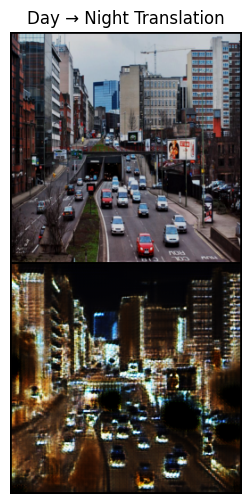

In [10]:
G_AB.eval()
real_A, _ = next(iter(dataloader))
real_A = real_A.to(device)

with torch.no_grad():
    fake_B = G_AB(real_A)

img_grid = make_grid(
    torch.cat([real_A.cpu(), fake_B.cpu()], dim=0),
    nrow=real_A.size(0),
    normalize=True
)

plt.figure(figsize=(12, 6))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Day → Night Translation")
plt.show()

## **Thank You for Reading!**

Thank you for taking the time to explore this notebook on **Day ↔ Night Image Translation using CycleGAN** 🌗🌃  

I hope this project helped you understand how **unpaired image-to-image translation** works and how **Generative Adversarial Networks** can be applied to real-world computer vision problems.

If you found this notebook useful:
- 💬 Feel free to leave **feedback or suggestions**
- 🔁 Share it with others interested in **Generative AI & Computer Vision**

Happy learning and keep experimenting with **GenAI** 🚀✨